# MLP
This is the first of many notebooks that investigate insights and differences between deep learning architectures from MLPs and CNNs. This focuses on the FashionMNIST dataset, an image dataset of various clothing items labeled by what they are. The images are relative simple, being 28x28 pixels, allowing for a image-based multiclass classification task.

This first notebook is an introduction to the dataset and deeper insights about initialization, architecture depth/width, and dropout that will not be as rigorously tested in the future notebooks.

## Topics
1. Data visualization
2. MLPs for image classification
3. Initialization
4. Depth vs Width
5. Sufficiency of Architecture
6. Dropout and Symmetry
7. The Vanishing Gradient Problem

In [2]:
import torch
from torch import nn
from d2l import torch as d2l

In [3]:
import torch
import numpy as np
import random
import os

def set_pytorch_seed(seed: int = 42):
    os.environ["PYTHONHASHSEED"] = str(seed)
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False

## Data Visualization
The FashionMNIST dataset is loaded using many of D2L's functions, showing the power of object-oriented software design.

In [4]:
data = d2l.FashionMNIST(batch_size=128)

100.0%


Extracting ../data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ../data/FashionMNIST/raw



100.0%


Extracting ../data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ../data/FashionMNIST/raw



100.0%


Extracting ../data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ../data/FashionMNIST/raw



100.0%

Extracting ../data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ../data/FashionMNIST/raw



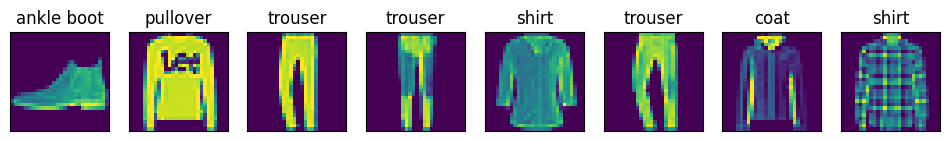

In [5]:
data.visualize(next(iter(data.val_dataloader())))

Each data sample is a 28 by 28 pixel image. There is only a single channel.

In [6]:
data.train[0][0].shape

torch.Size([1, 28, 28])

## Multilayer Perceptron
We start the baseline classification task with a multilayer perceptron. To start, we do a standard MLP on the dataset. In order to processes 2D image data, we must flatten out the images into a single dimension. The cross entropy loss is an appropriate loss function for classification. In a nutshell, the cross-entropy loss will measure the amount of difference between two distributions -- the true data generating distribution and the predicted label distribution.

In [7]:
class MLP(d2l.Module):
    def __init__(self, lr=0.1, num_classes=10, hidden_layers=(256,)):
        super().__init__()
        self.save_hyperparameters()
        self.hidden = nn.Sequential(
            *(nn.Sequential(nn.LazyLinear(h), nn.ReLU()) for h in hidden_layers)
        )
        self.out = nn.LazyLinear(num_classes)
    
    def forward(self, x):
        x = x.flatten(start_dim=1)
        hidden_out = self.hidden(x)
        return self.out(hidden_out)

    def loss(self, y_hat, y):
        return nn.functional.cross_entropy(y_hat, y)

In [8]:
def evaluate_model(model, data_loader):
    metric = d2l.Accumulator(2)
    model.eval()
    with torch.no_grad():
        for X, y in data_loader:
            y_hat = model(X)
            metric.add(d2l.accuracy(y_hat, y), y.numel())
    return metric[0] / metric[1]

As we can see below, the MLP has uninitialized parameters. For now, let's see what happens when we train this MLP.

In [9]:
mlp = MLP(hidden_layers=(128,64))
mlp.state_dict()

/home/jiwonjjeong/miniforge3/envs/d2l/lib/python3.9/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


OrderedDict([('hidden.0.0.weight', <UninitializedParameter>),
             ('hidden.0.0.bias', <UninitializedParameter>),
             ('hidden.1.0.weight', <UninitializedParameter>),
             ('hidden.1.0.bias', <UninitializedParameter>),
             ('out.weight', <UninitializedParameter>),
             ('out.bias', <UninitializedParameter>)])

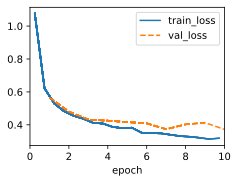

In [10]:
trainer = d2l.Trainer(max_epochs=10, num_gpus=1)
trainer.fit(mlp, data)

In [11]:
acc = evaluate_model(mlp, data.val_dataloader())
print("Final val accuracy:", acc)

Final val accuracy: 0.8655


A final validation accuracy is fairly high at 87.19%. Let's keep this as our benchmark as the most standard, vanilla MLP.

## Initialization
As observed, we did not initialize the model parameters, so the model trained with default weight starts. We should take care to initialize our parameters at the start. Controlling the initialization can improve the training speed and avoid numerical instability from exploding/vanishing gradients. In this section, we will compare the training of the same MLP under different initializations. We first start with the Xavier Initialization.

In [12]:
def init_weights(m):
    if isinstance(m, nn.Linear):
        nn.init.xavier_uniform_(m.weight)
        if m.bias is not None:
            nn.init.zeros_(m.bias)

In [13]:
mlpx = MLP(hidden_layers=(128,64))
mlpx.forward(next(iter(data.val_dataloader()))[0]) # next(iter(...)) gets the (X,y) tuple of next batch
mlpx.apply(init_weights)
mlpx.state_dict()['hidden.0.0.weight']

tensor([[ 0.0733, -0.0557,  0.0323,  ...,  0.0153, -0.0672, -0.0016],
        [ 0.0540, -0.0731, -0.0192,  ..., -0.0447, -0.0609,  0.0646],
        [-0.0279, -0.0672, -0.0799,  ..., -0.0696,  0.0647,  0.0732],
        ...,
        [-0.0725, -0.0415,  0.0385,  ..., -0.0513,  0.0771,  0.0093],
        [-0.0400, -0.0585, -0.0494,  ...,  0.0489,  0.0105,  0.0142],
        [-0.0650, -0.0516, -0.0803,  ...,  0.0159,  0.0259, -0.0101]])

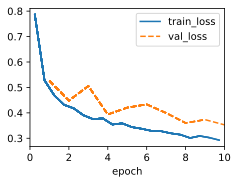

In [14]:
trainer = d2l.Trainer(max_epochs=10, num_gpus=1)
trainer.fit(mlpx, data)

In [15]:
accx = evaluate_model(mlpx, data.val_dataloader())
print("Final val accuracy:", accx)

Final val accuracy: 0.8728


Recall that our uninitialized baseline accuracy if 87.19% for the default initialization. It seems that the Xavier initialization performs similar. Let's compare to another common initialization scheme. This is the Kaiming Initialization. Specifically, we indicate that the ReLU activation will be used.

In [16]:
def init_weights(m):
    if isinstance(m, nn.Linear):
        nn.init.kaiming_uniform_(m.weight, nonlinearity='relu')
        if m.bias is not None:
            nn.init.zeros_(m.bias)

In [17]:
mlpk = MLP(hidden_layers=(128,64))
mlpk.forward(next(iter(data.val_dataloader()))[0]) # next(iter(...)) gets the (X,y) tuple of next batch
mlpk.apply(init_weights)
mlpk.state_dict()['hidden.0.0.weight']

tensor([[-0.0268, -0.0095,  0.0586,  ...,  0.0687, -0.0464,  0.0516],
        [-0.0857,  0.0785,  0.0839,  ...,  0.0516,  0.0635, -0.0257],
        [-0.0527, -0.0863, -0.0081,  ..., -0.0508,  0.0704,  0.0339],
        ...,
        [-0.0861,  0.0163,  0.0673,  ..., -0.0030, -0.0611,  0.0706],
        [-0.0466,  0.0679, -0.0666,  ...,  0.0783,  0.0434, -0.0446],
        [-0.0331, -0.0228,  0.0512,  ...,  0.0696, -0.0032, -0.0838]])

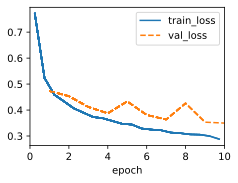

In [18]:
trainer = d2l.Trainer(max_epochs=10, num_gpus=1)
trainer.fit(mlpk, data)

In [19]:
acck = evaluate_model(mlpk, data.val_dataloader())
print("Final val accuracy:", acck)

Final val accuracy: 0.8724


Again, the Kaiming initialization for ReLU performs similar to the default initialization. This is expected, because the default initialization scheme for Linear layers in PyTorch uses the Kaiming initialization.

As an additional comparison, let's also see what happens when we perform more naive initializations. For example, let's initialize all the parameter values to the same number, 0.

In [20]:
def init_weights_zeros(m):
    if isinstance(m, nn.Linear):
        nn.init.zeros_(m.weight)
        if m.bias is not None:
            nn.init.zeros_(m.bias)

mlpz = MLP(hidden_layers=(128,64))
mlpz.forward(next(iter(data.val_dataloader()))[0]) # next(iter(...)) gets the (X,y) tuple of next batch
mlpz.apply(init_weights_zeros)
mlpz.state_dict()['hidden.0.0.weight']

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])

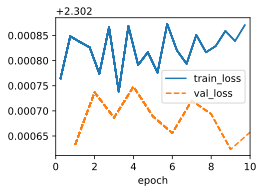

In [21]:
trainer = d2l.Trainer(max_epochs=10, num_gpus=1)
trainer.fit(mlpz, data)

In [22]:
accz = evaluate_model(mlpz, data.val_dataloader())
print("Final val accuracy:", accz)

Final val accuracy: 0.1


Yikes! This is definitely worse than the other common initializations. Even convergence is difficult with this poor initialization. What if we choose something in between this naive and the Kaiming or Xaivier initializations? Initializing the weights across a uniform distribution sounds like a possible strategy.

In [23]:
def init_weights_uniform(m):
    if isinstance(m, nn.Linear):
        nn.init.uniform_(m.weight, a=0.0, b=1.0)
        if m.bias is not None:
            nn.init.zeros_(m.bias)

mlpu = MLP(hidden_layers=(128,64))
mlpu.forward(next(iter(data.val_dataloader()))[0]) # next(iter(...)) gets the (X,y) tuple of next batch
mlpu.apply(init_weights_uniform)
mlpu.state_dict()['hidden.0.0.weight']

tensor([[0.1518, 0.5517, 0.6161,  ..., 0.0266, 0.6942, 0.3682],
        [0.5133, 0.7855, 0.6162,  ..., 0.3675, 0.8961, 0.9271],
        [0.7698, 0.1220, 0.0863,  ..., 0.6727, 0.9452, 0.6577],
        ...,
        [0.6728, 0.4154, 0.3930,  ..., 0.8357, 0.1078, 0.0307],
        [0.0572, 0.4995, 0.1531,  ..., 0.1951, 0.3045, 0.3322],
        [0.5302, 0.1742, 0.9850,  ..., 0.3817, 0.6388, 0.9069]])

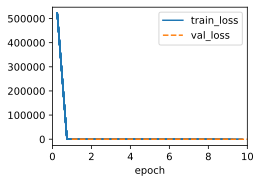

In [24]:
trainer = d2l.Trainer(max_epochs=10, num_gpus=1)
trainer.fit(mlpu, data)

In [25]:
accu = evaluate_model(mlpu, data.val_dataloader())
print("Final val accuracy:", accu)

Final val accuracy: 0.1


Still yikes! It seems like the uniform initialization also leads to poor (or at least slow) convergence. These last two examples (zero initialization and uniform initialization) more clearly show that a good initialization strategy is important to achieving (efficient) convergence.

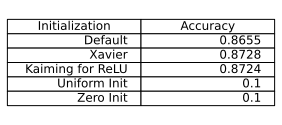

In [26]:
# Summarize findings
import matplotlib.pyplot as plt

col1 = ["Default", "Xavier", "Kaiming for ReLU", "Uniform Init", "Zero Init"]
col2 = [acc, accx,acck, accu, accz]

# Create figure
fig, ax = plt.subplots(figsize=(4, 2))
ax.axis("off")  # Hide axes

# Combine into rows
table_data = list(zip(col1, col2))

# Create table
table = ax.table(
    cellText=table_data,
    colLabels=["Initialization", "Accuracy"],
    loc="center"
)

table.auto_set_font_size(False)
table.set_fontsize(12)
table.scale(1.2, 1.2)

plt.show()

Though these are not rigorous tests to prove any reliable results about different initializations. It is clear that the initialization does affect the speed at which parameters converge. In more complex algorithms, the initialization may also be necessary to prevent numerical instability. For the rest of this investigation, the Kaiming initialization for ReLU will be used. It is also the empirically best result in our very crude experiment.

In [27]:
def init_weights(m):
    if isinstance(m, nn.Linear):
        nn.init.xavier_uniform_(m.weight)
        if m.bias is not None:
            nn.init.zeros_(m.bias)

## Width vs Depth
The next question is, how does depth matter? MLPs are universal function approximators and an infinitely wide single hidden layer MLP can approximate any function. However, we are typically constrained by memory and compute, so increasing depth is considered. Typically MLP depth contributes to higher complexity boolean and function representations with the same number of neurons. 

This following experiment will vary the distribution of the SAME number of neurons between a single layer or many layers. To avoid confounding factors of the first layer size, the architectures will vary only in the second and third hidden layers. Additionally, all layer sizes will be held above 10 (the label cardinality).

Layer sizes: [10, 10, 10], Final val accuracy: 0.8356


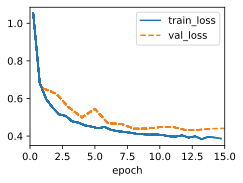

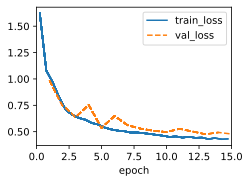

In [63]:
first_hidden_layer_size = 10
variant_1_layer_sizes = [20]
variant_2_layer_sizes = [10, 10]
accuracies = []

for layer_sizes in [variant_1_layer_sizes, variant_2_layer_sizes]:
    mlp_model = MLP(hidden_layers=(first_hidden_layer_size, *layer_sizes))
    mlp_model.forward(next(iter(data.val_dataloader()))[0]) # next(iter(...)) gets the (X,y) tuple of next batch
    mlp_model.apply(init_weights)
    trainer = d2l.Trainer(max_epochs=15, num_gpus=1)
    trainer.fit(mlp_model, data)
    acc = evaluate_model(mlp_model, data.val_dataloader())
    accuracies.append(acc)
    print(f"Layer sizes: {[first_hidden_layer_size] + layer_sizes}, Final val accuracy: {acc}")

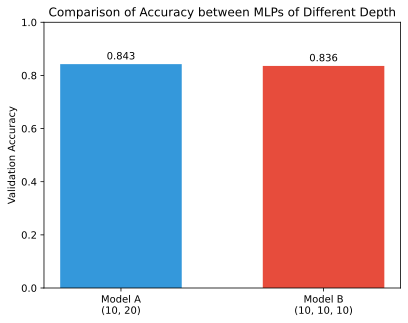

In [65]:
import matplotlib.pyplot as plt

models = ['Model A\n(10, 20)', 'Model B\n(10, 10, 10)']

# Create the bar chart
plt.bar(models, accuracies, color=['#3498db', '#e74c3c'], width=0.6)

# Adding labels and title
plt.ylabel('Validation Accuracy')
plt.title('Comparison of Accuracy between MLPs of Different Depth')
plt.ylim(0, 1.0)  # Setting y-axis limit for accuracy

# Add text labels on top of the bars
for i, acc in enumerate(accuracies):
    plt.text(i, acc + 0.01, f'{acc:.3f}', ha='center', va='bottom')
plt.show()

Interestingly, it seems that the model with less depth still performed better when there was a constraint of the same number of neurons. Through it is theoretically known that deeper architectures can create more complex operations with less neurons, the following section may explain why the deeper network does not always perform better than its wider counterpart.

## Sufficiency of Architecture
Although we consider MLPs as universal function approximaters, not all MLP architectures can represent every function. An extreme example is if the very MLP hidden layer has a size (width) of one. We would condense all the rich, input signals into a single linear boundary and lose a lot of the granularity in the data. This issue of losing granuarity with narrow layers is concerned with the "sufficiency of architecture", and it explains why deeper, narrow networks may not always perform better than their shallow, wider counterparts.

Without knowing the required sufficiency of architecture, it is often easier to intentionally choose a large layer width and overparameterize. Overparameterized architectures often tend to train better as well. Let's visualize some of these claims through changing the depth and width of the MLPs.

In [28]:
# Make sure to initialize with Kaiming for ReLU
def init_weights(m):
    if isinstance(m, nn.Linear):
        nn.init.kaiming_uniform_(m.weight, nonlinearity='relu')
        if m.bias is not None:
            nn.init.zeros_(m.bias)

In [29]:
mlp = MLP(hidden_layers=(128,64))
mlp.forward(next(iter(data.val_dataloader()))[0]) # next(iter(...)) gets the (X,y) tuple of next batch
mlp.apply(init_weights)

MLP(
  (hidden): Sequential(
    (0): Sequential(
      (0): Linear(in_features=784, out_features=128, bias=True)
      (1): ReLU()
    )
    (1): Sequential(
      (0): Linear(in_features=128, out_features=64, bias=True)
      (1): ReLU()
    )
  )
  (out): Linear(in_features=64, out_features=10, bias=True)
)

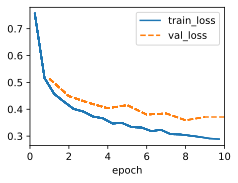

In [30]:
trainer = d2l.Trainer(max_epochs=10, num_gpus=1)
trainer.fit(mlp, data)

In [31]:
acc = evaluate_model(mlp, data.val_dataloader())
print("Final val accuracy:", acc)

Final val accuracy: 0.8665


Now let's see how the model performs when we do an extreme architecture with a very small initial hidden layer size.

In [32]:
mlp_inverted = MLP(hidden_layers=(8,64))
mlp_inverted.forward(next(iter(data.val_dataloader()))[0]) # next(iter(...)) gets the (X,y) tuple of next batch
mlp_inverted.apply(init_weights)

MLP(
  (hidden): Sequential(
    (0): Sequential(
      (0): Linear(in_features=784, out_features=8, bias=True)
      (1): ReLU()
    )
    (1): Sequential(
      (0): Linear(in_features=8, out_features=64, bias=True)
      (1): ReLU()
    )
  )
  (out): Linear(in_features=64, out_features=10, bias=True)
)

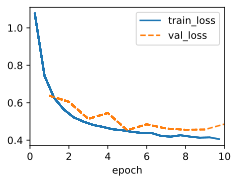

In [33]:
trainer = d2l.Trainer(max_epochs=10, num_gpus=1)
trainer.fit(mlp_inverted, data)

In [34]:
acc = evaluate_model(mlp_inverted, data.val_dataloader())
print("Final val accuracy:", acc)

Final val accuracy: 0.82


Oddly, it seems that the results are not too different! But what if we go even more extreme?

In [35]:
mlp_inverted_ex = MLP(hidden_layers=(2,64))
mlp_inverted_ex.forward(next(iter(data.val_dataloader()))[0]) # next(iter(...)) gets the (X,y) tuple of next batch
mlp_inverted_ex.apply(init_weights)

MLP(
  (hidden): Sequential(
    (0): Sequential(
      (0): Linear(in_features=784, out_features=2, bias=True)
      (1): ReLU()
    )
    (1): Sequential(
      (0): Linear(in_features=2, out_features=64, bias=True)
      (1): ReLU()
    )
  )
  (out): Linear(in_features=64, out_features=10, bias=True)
)

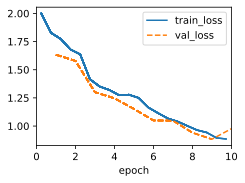

In [36]:
trainer = d2l.Trainer(max_epochs=10, num_gpus=1)
trainer.fit(mlp_inverted_ex, data)

In [37]:
acc = evaluate_model(mlp_inverted_ex, data.val_dataloader())
print("Final val accuracy:", acc)

Final val accuracy: 0.6113


Yikes! Now we see some more poor performance with an insufficient architecture. Let's visualize how the accuracy of the model changes with changing the first hidden layer size. We hold the hidden layer size of the second hidden layer the same throughout this section at 64.

Hidden layer size: 2, Final val accuracy: 0.5174


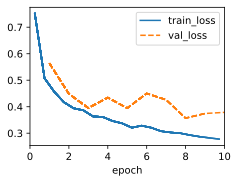

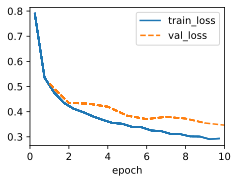

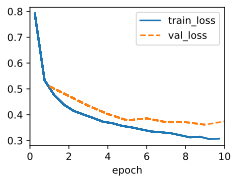

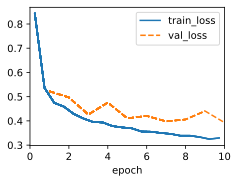

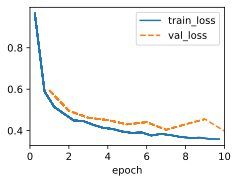

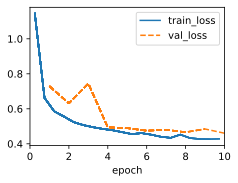

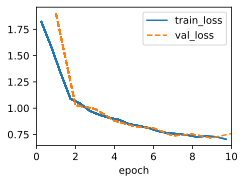

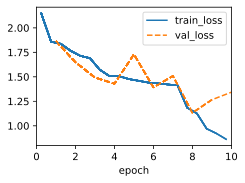

In [38]:
first_hidden_layer_sizes = [256, 128, 64, 32, 16, 8, 4, 2]
accuracies = []

for size in first_hidden_layer_sizes:
    mlp_model = MLP(hidden_layers=(size, 64))
    mlp_model.forward(next(iter(data.val_dataloader()))[0]) # next(iter(...)) gets the (X,y) tuple of next batch
    mlp_model.apply(init_weights)
    trainer = d2l.Trainer(max_epochs=10, num_gpus=1)
    trainer.fit(mlp_model, data)
    acc = evaluate_model(mlp_model, data.val_dataloader())
    accuracies.append(acc)
    print(f"Hidden layer size: {size}, Final val accuracy: {acc}")

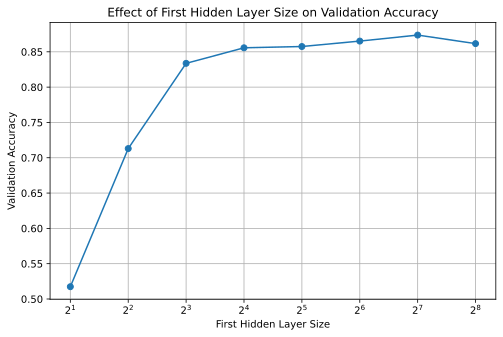

In [39]:
import matplotlib.pyplot as plt
plt.figure(figsize=(8, 5))
plt.plot(first_hidden_layer_sizes, accuracies, marker='o')
plt.xscale('log', base=2)
plt.xlabel('First Hidden Layer Size')
plt.ylabel('Validation Accuracy')
plt.title('Effect of First Hidden Layer Size on Validation Accuracy')
plt.grid(True)
plt.show()

It seems that for this classification task, the minimum sufficient archiecture is quickly met with an initial hidden layer size of 8+. The point of this investigation is to show that such relationship between the granularity of the first layer and the representative power of the entire architecture exists (especially at extremeley small first hidden layer sizes).

In practical cases, we often do not know the exact minimum sufficient architecture for an ML task and dataset, so it is easier to overparameterize. Overparameterization even sometimes helps the model performance and generalization, a counterintuitive result to how we perceive overparameterization in algorithms like logistic regression. We see this in our experiment, where overparameterization continues to improve generalization, rather than causing some decrease due to overfitting. Thus, our final architecture will also lean toward overparameterization and avoid risking an insufficient architecture.

### Dropout and Symmetry

So far, we have been looking at neurons and properties like height and initializations. But what happens when we compare two neurons of a single hidden layer? Because MLPs consist of fully-connected "feed-forward" layers, each neuron takes all the previous inputs. And we know that the activation function is also applied to all neuron outputs. So how can a network differentiate between two neurons of the same layer? With our current setup, the network can only tell the difference by the parameters. Thus, if two neurons start with the exact same parameters, the network will never be able to distinguish them. There is some symmetry that cannot be broken between the two neurons.

We can break the symmetry between neurons of a layer by adding random (or "stochastic") deactivation of neurons during training. We call this dropout, where each neuron has a random chance to be turned off during the training. This stochasticity will break the symmetry allowing two neurons with identical initial parameters to diverge in their learning.

Let's visualize how dropout can break neuron symmetry by initializing neurons to the same value of 0.5. Bias parameters are initialized to zero.

In [76]:
# This is an MLP with no dropout and all hidden layers initialized to the same weights
def init_same(m):
    if isinstance(m, nn.Linear):
        nn.init.constant_(m.weight, 0.5)
        if m.bias is not None:
            nn.init.zeros_(m.bias)

mlp_model = MLP(hidden_layers=(10,5))
mlp_model.forward(next(iter(data.val_dataloader()))[0]) # next(iter(...)) gets the (X,y) tuple of next batch
mlp_model.apply(init_same)

/home/jiwonjjeong/miniforge3/envs/d2l/lib/python3.9/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


MLP(
  (hidden): Sequential(
    (0): Sequential(
      (0): Linear(in_features=784, out_features=10, bias=True)
      (1): ReLU()
    )
    (1): Sequential(
      (0): Linear(in_features=10, out_features=5, bias=True)
      (1): ReLU()
    )
  )
  (out): Linear(in_features=5, out_features=10, bias=True)
)

In [77]:
# MLP with dropout layers added
class MLP_dropout(d2l.Module):
    def __init__(self, lr=0.1, num_classes=10, hidden_layers=(256,)):
        super().__init__()
        self.save_hyperparameters()
        self.hidden = nn.Sequential(
            *(nn.Sequential(nn.LazyLinear(h), nn.ReLU(), nn.Dropout()) for h in hidden_layers)
        )
        self.out = nn.LazyLinear(num_classes)
    
    def forward(self, x):
        x = x.flatten(start_dim=1)
        hidden_out = self.hidden(x)
        return self.out(hidden_out)

    def loss(self, y_hat, y):
        return nn.functional.cross_entropy(y_hat, y)

In [78]:
mlp_model_with_dropout = MLP_dropout(hidden_layers=(10,5))
mlp_model_with_dropout.forward(next(iter(data.val_dataloader()))[0]) # next(iter(...)) gets the (X,y) tuple of next batch
mlp_model_with_dropout.apply(init_same)

Traceback (most recent call last):
  File "/home/jiwonjjeong/miniforge3/envs/d2l/lib/python3.9/multiprocessing/util.py", line 300, in _run_finalizers
    finalizer()
  File "/home/jiwonjjeong/miniforge3/envs/d2l/lib/python3.9/multiprocessing/util.py", line 224, in __call__
    res = self._callback(*self._args, **self._kwargs)
  File "/home/jiwonjjeong/miniforge3/envs/d2l/lib/python3.9/multiprocessing/util.py", line 133, in _remove_temp_dir
    rmtree(tempdir)
  File "/home/jiwonjjeong/miniforge3/envs/d2l/lib/python3.9/shutil.py", line 740, in rmtree
    onerror(os.rmdir, path, sys.exc_info())
  File "/home/jiwonjjeong/miniforge3/envs/d2l/lib/python3.9/shutil.py", line 738, in rmtree
    os.rmdir(path)
OSError: [Errno 39] Directory not empty: '/tmp/pymp-n6k2eztj'


MLP_dropout(
  (hidden): Sequential(
    (0): Sequential(
      (0): Linear(in_features=784, out_features=10, bias=True)
      (1): ReLU()
      (2): Dropout(p=0.5, inplace=False)
    )
    (1): Sequential(
      (0): Linear(in_features=10, out_features=5, bias=True)
      (1): ReLU()
      (2): Dropout(p=0.5, inplace=False)
    )
  )
  (out): Linear(in_features=5, out_features=10, bias=True)
)

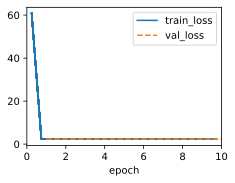

In [79]:
trainer = d2l.Trainer(max_epochs=10, num_gpus=1)
trainer.fit(mlp_model, data)

In [80]:
acc = evaluate_model(mlp_model, data.val_dataloader())
print("Final val accuracy:", acc)

Final val accuracy: 0.1


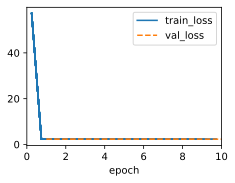

In [81]:
trainer = d2l.Trainer(max_epochs=10, num_gpus=1)
trainer.fit(mlp_model_with_dropout, data)

In [82]:
acc_dropout = evaluate_model(mlp_model_with_dropout, data.val_dataloader())
print("Final val accuracy:", acc_dropout)

Final val accuracy: 0.1


Both models appeared to have trained very poorly, likely due to a bad initialization. However, we can still see the effect that dropout has on breaking symmetries in the MLP by directly comparing the parameter values.

In [83]:
mlp_model.state_dict()['hidden.1.0.weight']

tensor([[-54.1716, -54.1716, -54.1716, -54.1716, -54.1716, -54.1716, -54.1716,
         -54.1716, -54.1716, -54.1716],
        [-54.1716, -54.1716, -54.1716, -54.1716, -54.1716, -54.1716, -54.1716,
         -54.1716, -54.1716, -54.1716],
        [-54.1716, -54.1716, -54.1716, -54.1716, -54.1716, -54.1716, -54.1716,
         -54.1716, -54.1716, -54.1716],
        [-54.1716, -54.1716, -54.1716, -54.1716, -54.1716, -54.1716, -54.1716,
         -54.1716, -54.1716, -54.1716],
        [-54.1716, -54.1716, -54.1716, -54.1716, -54.1716, -54.1716, -54.1716,
         -54.1716, -54.1716, -54.1716]])

As seen, the MLP trained without dropout did not have any differences within the parameter values within a layer. Note how the MLP without dropout still did have changed parameter values from the original 0.5 or 0 initialization, but all the neurons of layer were just treated identically. This is bad because our neurons cannot provide additional pattern learning, but still occupy memory and compute burden.

In [84]:
mlp_model_with_dropout.state_dict()['hidden.1.0.weight']

tensor([[ -80.0822,  -49.0304,  -81.9626,  -76.2116,  -79.2674, -101.5035,
          -76.9727,  -84.2413,  -80.0687,  -91.5285],
        [ -32.3422,  -30.5604,  -46.2135,  -30.9786,  -37.4825,  -45.3800,
          -39.3179,  -35.9266,  -31.5416,  -44.0486],
        [ -61.0426,  -37.8204,  -56.0814,  -53.8071,  -54.1844,  -54.9749,
          -65.6120,  -40.6786,  -55.4396,  -60.2361],
        [ -54.3100,  -41.1083,  -58.1531,  -36.9339,  -54.7782,  -64.3215,
          -53.8604,  -43.0992,  -63.2709,  -57.7413],
        [ -28.4859,  -23.3502,  -34.2486,  -27.1069,  -31.7964,  -30.8873,
          -25.0266,  -35.0329,  -31.8150,  -33.3080]])

Fortunately, the MLP trained with dropout did have differences within a layer, even though its parameters were also initialized to the same value. Thus, dropout is an effective strategy to break symmetry of neurons within layers of a model.

In addition to breaking symmetry, dropout is also observed to reduce overfitting, so it is a useful technique in training deep networks.

## The Vanishing Gradient Problem
Also observed in the previous experiment, the vanishing gradient problem describes how early layers of a network are not updated as quickly. The gradient descent from the output gets numerically smaller as the gradient flows towards the earlier layers. Reviewing either one of the parameters from the previous experiment shows how the initial layer does not change much from the initialized 0.5 value, while the later layers do change in response to training.

In [85]:
mlp_model.state_dict()['hidden.0.0.weight']

tensor([[0.5000, 0.5000, 0.4999,  ..., 0.4800, 0.4907, 0.4980],
        [0.5000, 0.5000, 0.4999,  ..., 0.4800, 0.4907, 0.4980],
        [0.5000, 0.5000, 0.4999,  ..., 0.4800, 0.4907, 0.4980],
        ...,
        [0.5000, 0.5000, 0.4999,  ..., 0.4800, 0.4907, 0.4980],
        [0.5000, 0.5000, 0.4999,  ..., 0.4800, 0.4907, 0.4980],
        [0.5000, 0.5000, 0.4999,  ..., 0.4800, 0.4907, 0.4980]])

In [86]:
mlp_model_with_dropout.state_dict()['hidden.0.0.weight']

tensor([[0.5000, 0.5000, 0.5000,  ..., 0.4998, 0.5000, 0.5000],
        [0.5000, 0.5000, 0.5000,  ..., 0.4977, 0.4994, 0.5000],
        [0.5000, 0.5000, 0.5000,  ..., 0.4977, 0.4994, 0.5000],
        ...,
        [0.5000, 0.5000, 0.5000,  ..., 0.4977, 0.4994, 0.5000],
        [0.5000, 0.5000, 0.5000,  ..., 0.4978, 0.4994, 0.5000],
        [0.5000, 0.5000, 0.5000,  ..., 0.4978, 0.4994, 0.5000]])

As seen, both of the initial linear layers of the MLPs were barely updated from the initialized 0.5 value. This reflects how earlier layers of deep MLPs can struggle to train, further making initialization an important tool for practical convergence of deep networks. For comparison, we can see how much the other layer parameters were updated just one layer ahead.

In [88]:
mlp_model_with_dropout.state_dict()['hidden.1.0.weight']

tensor([[ -80.0822,  -49.0304,  -81.9626,  -76.2116,  -79.2674, -101.5035,
          -76.9727,  -84.2413,  -80.0687,  -91.5285],
        [ -32.3422,  -30.5604,  -46.2135,  -30.9786,  -37.4825,  -45.3800,
          -39.3179,  -35.9266,  -31.5416,  -44.0486],
        [ -61.0426,  -37.8204,  -56.0814,  -53.8071,  -54.1844,  -54.9749,
          -65.6120,  -40.6786,  -55.4396,  -60.2361],
        [ -54.3100,  -41.1083,  -58.1531,  -36.9339,  -54.7782,  -64.3215,
          -53.8604,  -43.0992,  -63.2709,  -57.7413],
        [ -28.4859,  -23.3502,  -34.2486,  -27.1069,  -31.7964,  -30.8873,
          -25.0266,  -35.0329,  -31.8150,  -33.3080]])